In [4]:
# input_size = (5, 8, 1)    # for MFCC
# input_size = (8, 8, 1)    # for mel-spectrogram
input_size = (64, 64, 1)    # for mel-spectrogram as image
batch_size = 32
init_lr = 1e-3

num_classes = 10

early_stopping_patience = 15
reduce_lr_patience = 8

In [8]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2023-06-01 10:59:21--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  4.63MB/s    in 27m 42s 

2023-06-01 11:27:04 (3.46 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [5]:
import pandas as pd
import librosa
import librosa.feature
import numpy as np
import os
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
import cv2 as cv


def mel_spectrogram_image_features_extractor(file, n_mels=64):
    audio, sample_rate = librosa.load(file)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    log_mel_spectrogram = cv.resize(log_mel_spectrogram, [64, 64])
    return log_mel_spectrogram


print("\n-----Data preparation-----\n")
start = datetime.now()
audio_dataset_path = "UrbanSound8K/audio/"
metadata = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")

extracted_features = []
fold_col_ind = np.where(metadata.columns.to_numpy() == 'fold')[0][0]
slice_file_name_col_ind = np.where(metadata.columns.to_numpy() == 'slice_file_name')[0][0]
class_col_ind = np.where(metadata.columns.to_numpy() == 'class')[0][0]
for index_num, row in enumerate(metadata.values):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),
                             'fold' + str(row[fold_col_ind]) + '/',
                             str(row[slice_file_name_col_ind]))
    final_class_labels = row[class_col_ind]

    # Choose the type of features: MFCC or mel-spectrogram
    # data = mfcc_features_extractor(file_name, 40)
    # data = mel_spectrogram_features_extractor(file_name)
    data = mel_spectrogram_image_features_extractor(file_name)

    extracted_features.append([data.reshape(input_size), final_class_labels])
    print("\r", index_num + 1, "/8732", end="")
print("\r\n")

extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
X = np.array(extracted_features_df["feature"].tolist())
y = np.array(extracted_features_df["class"].tolist())
print("X.shape: ", X.shape)

label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train.shape: ", X_train.shape)
duration = datetime.now() - start
print("\n-----Data ready for training (preparation time ", duration, ")-----\n")


-----Data preparation-----

 3556 /8732

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


 8326 /8732

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(


 8330 /8732

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


 8732 /8732

X.shape:  (8732, 64, 64, 1)
X_train.shape:  (6985, 64, 64, 1)

-----Data ready for training (preparation time  0:40:09.022790 )-----



In [6]:
import tensorflow as tf


# Residual block
def res_block(filters, x, down_sample=False):
    strides = [2, 1] if down_sample else [1, 1]
    kernel_initializer = "he_normal"

    t = x

    # Prvi konvolucioni blok
    y = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=strides[0], padding='same',
                               kernel_initializer=kernel_initializer)(t)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    # Drugi konvolucioni blok
    y = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=strides[1], padding='same',
                               kernel_initializer=kernel_initializer)(y)
    y = tf.keras.layers.BatchNormalization()(y)

    # Sloj 1x1 konvolucije koji služi da izjednači broj filtara zbog sabiranja izlaznih mapa
    if down_sample:
        t = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=2, padding='same',
                                   kernel_initializer=kernel_initializer)(t)
        t = tf.keras.layers.BatchNormalization()(t)

    # Sabiranje i ReLU aktivacija
    y = tf.keras.layers.add([t, y])
    y = tf.keras.layers.Activation('relu')(y)
    return y


# ResNet18 model creation
def create_model():
    input = tf.keras.layers.Input(input_size)

    conv0 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer="he_normal")(input)
    conv0 = tf.keras.layers.BatchNormalization()(conv0)
    conv0 = tf.keras.layers.Activation('relu')(conv0)
    pool0 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(conv0)

    res1 = res_block(64, pool0)
    res2 = res_block(64, res1)

    res3 = res_block(128, res2, down_sample=True)
    res4 = res_block(128, res3)

    res5 = res_block(256, res4, down_sample=True)
    res6 = res_block(256, res5)

    res7 = res_block(512, res6, down_sample=True)
    res8 = res_block(512, res7)

    y = tf.keras.layers.GlobalAveragePooling2D()(res8)
    y = tf.keras.layers.Flatten()(y)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(y)

    model = tf.keras.models.Model(inputs=input, outputs=output)
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

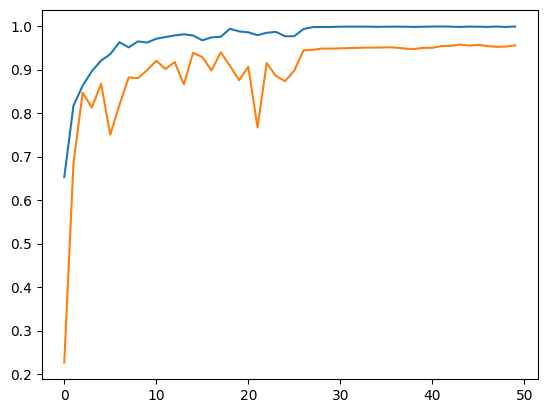

In [7]:
import matplotlib.pyplot as plt


########################################################################################################################
# CREATE MODEL
########################################################################################################################

model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()


########################################################################################################################
# CALLBACKS
########################################################################################################################

# path = "models/MFCC40 - 30 epochs (of 100) earlystop/"
path = "drive/My Drive/Colab Notebooks/models/"

save_model = tf.keras.callbacks.ModelCheckpoint(path + "trained_model.h5",
                                                monitor='val_categorical_accuracy', mode='max',
                                                verbose=1, save_best_only=True)

csv_logger = tf.keras.callbacks.CSVLogger(path + 'training.csv')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1,
                                                  patience=early_stopping_patience, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', mode='max', verbose=1,
                                                 factor=0.1, patience=reduce_lr_patience)



########################################################################################################################
# TRAINING MODEL
########################################################################################################################

start = datetime.now()
hist = model.fit(X_train,
                 y_train,
                 epochs=50,
                 validation_data=(X_test, y_test),
                 shuffle=True,
                 callbacks=[save_model, csv_logger, early_stopping, reduce_lr],
                 verbose=2)

duration = datetime.now() - start
print("Training duration: ", duration)

model.save(path + "trained_model.h5", include_optimizer=False)

plt.clf()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.savefig(path + "training_loss.png")

plt.clf()
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.savefig(path + "training_accuracy.png")


########################################################################################################################
# EVALUATE MODEL
########################################################################################################################

res_train = model.evaluate(X_train, y_train)
res_test = model.evaluate(X_test, y_test)
print(res_train)
print(res_test)


----------WITH K-FOLD CROSS VALIDATION-----------------

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50

Epoch 1: val_categorical_accuracy improved from -inf to 0.52234, saving model to drive/My Drive/Colab Notebooks/models/1/trained_model.h5
246/246 - 21s - loss: 0.9967 - categorical_accuracy: 0.6697 - val_loss: 1.9064 - val_categorical_accuracy: 0.5223 - lr: 0.0010 - 21s/epoch - 85ms/step
Epoch 2/50

Epoch 2: val_categorical_accuracy did not improve from 0.52234
246/246 - 5s - loss: 0.4933 - categorical_accuracy: 0.8403 - val_loss: 2.8865 - val_categorical_accuracy: 0.3711 - lr: 0.0010 - 5s/epoch - 22ms/step
Epoch 3/50

Epoch 3: val_categorical_accuracy improved from 0.52234 to 0.54983, saving model to drive/My Drive/Colab Notebooks/models/1/trained_model.h5
246/246 - 7s - loss: 0.3332 - categorical_accuracy: 0.8876 - val_loss: 2.4074 - val_categorical_accuracy: 0.5498 - lr: 0.0010 - 7s/epoch - 30ms/step
Epoch 4/50

Epoch 4: val_categorical_accuracy did not improve from 0.54983
2

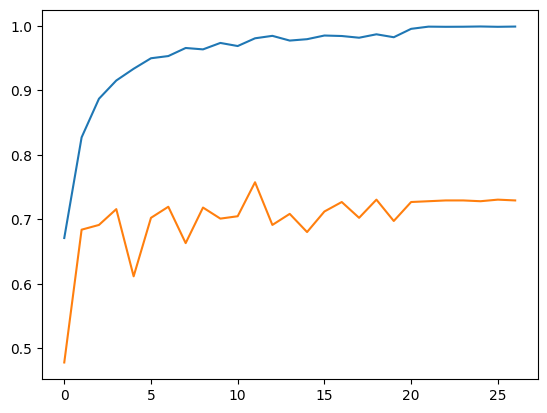

In [54]:
fold_id_list = metadata['fold'].to_numpy()
all_indices = np.arange(0, X.shape[0])
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for i in range(1,11):
  test_indices = np.where(fold_id_list == i)[0]
  train_indices = np.delete(all_indices, test_indices)
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
 

  model = create_model()
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=[tf.keras.metrics.categorical_accuracy])


  # path = "models/MFCC40 - 30 epochs (of 100) earlystop/"
  path = "drive/My Drive/Colab Notebooks/models/" + str(i) + "/"

  save_model = tf.keras.callbacks.ModelCheckpoint(path + "trained_model.h5",
                                                  monitor='val_categorical_accuracy', mode='max',
                                                  verbose=1, save_best_only=True)

  csv_logger = tf.keras.callbacks.CSVLogger(path + 'training.csv')

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1,
                                                    patience=early_stopping_patience, restore_best_weights=True)

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', mode='max', verbose=1,
                                                  factor=0.1, patience=reduce_lr_patience)



  print('------------------------------------------------------------------------')
  print(f'Training for fold {i} ...')


  start = datetime.now()
  hist = model.fit(X_train,
                  y_train,
                  epochs=50,
                  validation_data=(X_test, y_test),
                  shuffle=True,
                  callbacks=[save_model, csv_logger, early_stopping, reduce_lr],
                  verbose=2)

  duration = datetime.now() - start
  print("Training duration of ", i, ". fold: ", duration)

  model.save(path + "trained_model.h5", include_optimizer=False)

  plt.clf()
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.savefig(path + "training_loss.png")

  plt.clf()
  plt.plot(hist.history['categorical_accuracy'])
  plt.plot(hist.history['val_categorical_accuracy'])
  plt.savefig(path + "training_accuracy.png")


  ########################################################################################################################
  # EVALUATE MODEL
  ########################################################################################################################

  res_train = model.evaluate(X_train, y_train)
  res_test = model.evaluate(X_test, y_test)
  print(res_train)
  print(res_test)
  train_losses.append(res_train[0])
  train_accuracies.append(res_train[1])
  test_losses.append(res_test[0])
  test_accuracies.append(res_test[1])


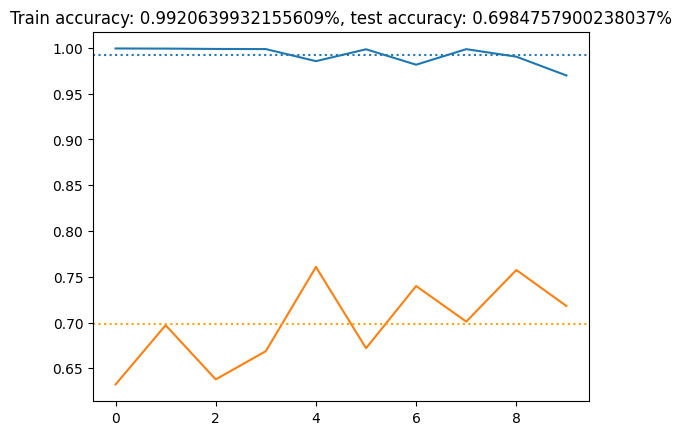

In [69]:
path = "drive/My Drive/Colab Notebooks/models/cv/"

avg_train_loss = np.mean(train_losses)
avg_test_loss = np.mean(test_losses)
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)

plt.clf()
plt.plot(train_losses)
plt.plot(test_losses)
plt.axhline(avg_train_loss, linestyle=":", color='tab:blue')
plt.axhline(avg_test_loss, linestyle=":", color='orange')
plt.title("Train loss: {}%, test loss: {}%".format(avg_train_loss, avg_test_loss))
plt.savefig(path + "loss_cv.png")

plt.clf()
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.axhline(avg_train_accuracy, linestyle=":", color='tab:blue')
plt.axhline(avg_test_accuracy, linestyle=":", color='orange')
plt.title("Train accuracy: {}%, test accuracy: {}%".format(avg_train_accuracy, avg_test_accuracy))
plt.savefig(path + "accuracy_cv.png")